# Cats vs Dogs -- with help from a pre-trained image classification model!

<img src="cat-dog-data/test/cat/cat.1500.jpg" width="250px"/> <img src="cat-dog-data/test/dog/dog.1500.jpg" width="250px"/>

#### We're going to use TensorFlow and Convolutional Neural Networks to identify whether a picture is a dog or a cat.

Side-note:  I think the dataset is biased against cats, because most of the cats I've looked at in this dataset look crazy, a bit ugly, or like they totally have it out for the dogs!

This dataset is a subset of the data that can be obtained at [Kaggle's Dogs Vs Cats page](https://www.kaggle.com/c/dogs-vs-cats/data).

The code below was motivated by Chollet's Deep Learning with Python book, in which you will find many, many more interesting details and tidbits about doing deep learning.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
tf.__version__

'2.9.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# tf.get_logger().setLevel('ERROR')

## Getting our data

Our data images are in folders that are already split up into training, test, and validation sets.  Furthermore, they are aleady split up into cat and dog folders.

The following image_dataset_from_directory gets class labels based on whether the images are retrieved from these "cat" or "dog" folders.

In [5]:
import os

In [6]:
os.path.join(os.getcwd(), "cat-dog-data", "train")

'/Users/bwinjum/git/UCLAX-23W-ML/Weeks/Week09/cat-dog-data/train'

In [7]:
train_dataset = image_dataset_from_directory(
    os.path.join(os.getcwd(), "cat-dog-data", "train"),
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(os.getcwd(), "cat-dog-data", "validation"),
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(os.getcwd(), "cat-dog-data", "test"),
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Metal device set to: Apple M1 Pro
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2023-03-05 16:11:44.994707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-05 16:11:44.994908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
train_ds = train_dataset.unbatch()
a = list(train_ds)

2023-03-05 16:11:45.648644: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
len(a)

2000

In [10]:
a[2][0].shape

TensorShape([180, 180, 3])

In [11]:
a[2][1]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [12]:
a[2][0][0][2]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([102.861115, 118.861115, 117.861115], dtype=float32)>

In [13]:
a[2][1]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

The label for image 2 is 1
The picture for image 2 is


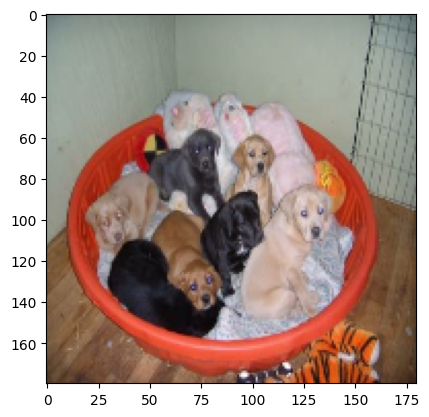

In [14]:
b = 2
print("The label for image",b,"is",a[b][1].numpy())
print("The picture for image",b,"is")
plt.imshow(a[b][0].numpy().astype('int32'));

# Using pre-trained model

We will try using a pre-trained model available through Keras Applications.  "Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning."
* https://keras.io/api/applications/

## Feature extraction without data augmentation

In [15]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [17]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

2023-03-05 16:11:53.918560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 93ms/step


2023-03-05 16:12:05.359056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


In [18]:
train_features.shape

(2000, 5, 5, 512)

In [19]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20


2023-03-05 16:12:44.329842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 17.9786 - accuracy: 0.9235

2023-03-05 16:12:45.543804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 14ms/step - loss: 17.9786 - accuracy: 0.9235 - val_loss: 8.1177 - val_accuracy: 0.9540
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5.5060 - accuracy: 0.9685 - val_loss: 4.2191 - val_accuracy: 0.9670
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 2.6012 - accuracy: 0.9800 - val_loss: 4.7089 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.3619 - accuracy: 0.9900 - val_loss: 5.2623 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.1440 - accuracy: 0.9910 - val_loss: 4.9437 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.8710 - accuracy: 0.9925 - val_loss: 4.7326 - val_accuracy: 0.9710
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.4818 - accuracy: 0.9945 - val_loss: 4.1945 - val_accuracy: 0.9760
Epoch 8/20
63/63 [=====

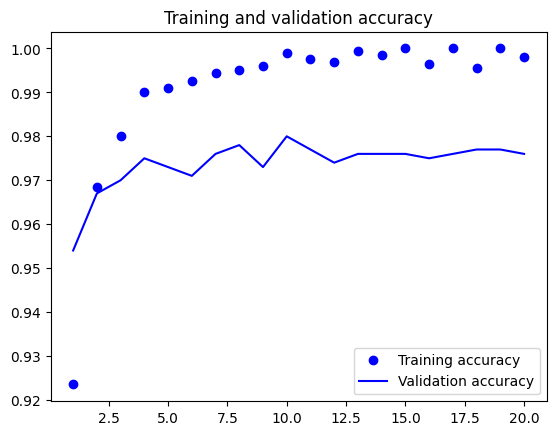

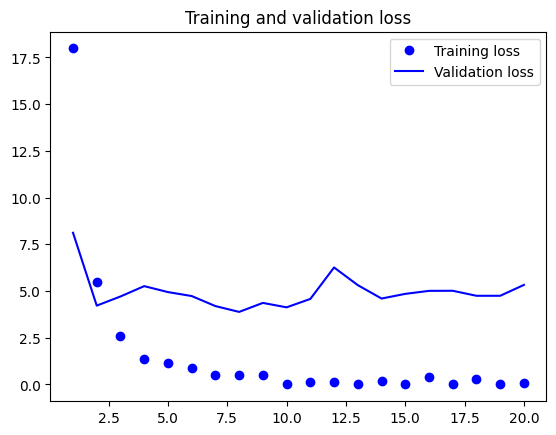

In [20]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Feature extraction with data augmentation

In [21]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [22]:
conv_base.trainable = True
len(conv_base.trainable_weights)

26

In [23]:
conv_base.trainable = False
len(conv_base.trainable_weights)

0

In [24]:
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


2023-03-05 16:13:03.715829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 23.9789 - accuracy: 0.8815

2023-03-05 16:13:19.812316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 22s 321ms/step - loss: 23.9789 - accuracy: 0.8815 - val_loss: 23.6197 - val_accuracy: 0.8910
Epoch 2/50
63/63 [==============================] - 20s 318ms/step - loss: 7.3272 - accuracy: 0.9420 - val_loss: 7.1096 - val_accuracy: 0.9550
Epoch 3/50
63/63 [==============================] - 20s 315ms/step - loss: 7.3519 - accuracy: 0.9460 - val_loss: 2.9880 - val_accuracy: 0.9740
Epoch 4/50
63/63 [==============================] - 20s 312ms/step - loss: 3.6686 - accuracy: 0.9635 - val_loss: 3.3673 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 20s 316ms/step - loss: 3.0761 - accuracy: 0.9620 - val_loss: 2.6937 - val_accuracy: 0.9800
Epoch 6/50
63/63 [==============================] - 20s 317ms/step - loss: 3.4911 - accuracy: 0.9660 - val_loss: 1.8972 - val_accuracy: 0.9800
Epoch 7/50
63/63 [==============================] - 20s 312ms/step - loss: 3.2823 - accuracy: 0.9600 - val_loss: 2.1031 - val_accuracy: 0.9790
Epoch 8/

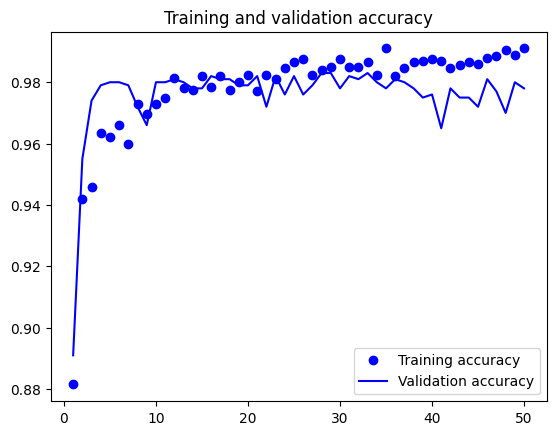

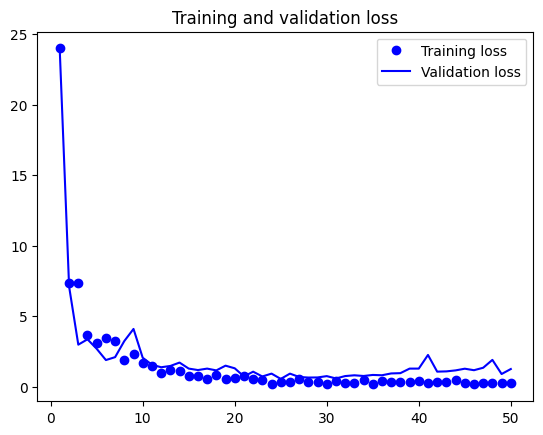

In [25]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2023-03-05 16:29:56.340892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 11s 153ms/step - loss: 0.8953 - accuracy: 0.9760
Test accuracy: 0.976


In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [28]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [29]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


2023-03-05 16:30:08.965356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.9875

2023-03-05 16:30:27.251403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 24s 355ms/step - loss: 0.3491 - accuracy: 0.9875 - val_loss: 1.1153 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - 22s 351ms/step - loss: 0.2403 - accuracy: 0.9910 - val_loss: 0.9461 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 22s 349ms/step - loss: 0.1799 - accuracy: 0.9915 - val_loss: 1.0095 - val_accuracy: 0.9750
Epoch 4/30
63/63 [==============================] - 22s 348ms/step - loss: 0.1849 - accuracy: 0.9915 - val_loss: 2.4561 - val_accuracy: 0.9610
Epoch 5/30
63/63 [==============================] - 22s 352ms/step - loss: 0.3019 - accuracy: 0.9895 - val_loss: 0.9654 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 22s 350ms/step - loss: 0.1378 - accuracy: 0.9915 - val_loss: 0.9345 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 22s 349ms/step - loss: 0.2232 - accuracy: 0.9920 - val_loss: 0.8963 - val_accuracy: 0.9820
Epoch 8/30

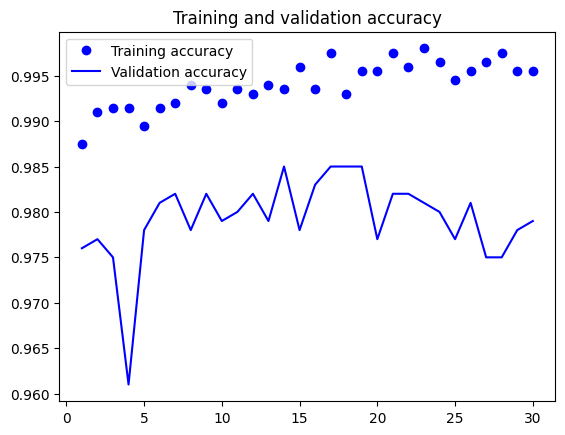

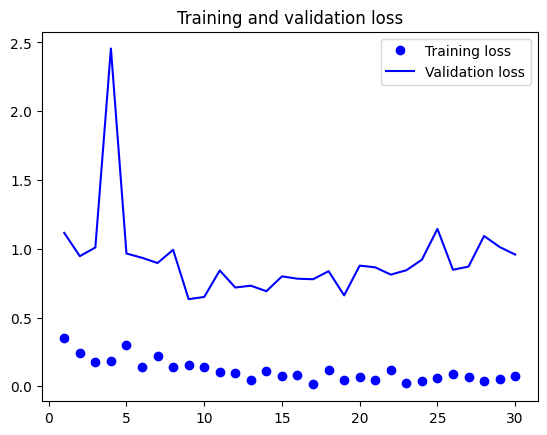

In [30]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [31]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2023-03-05 16:41:19.189453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 10s 153ms/step - loss: 0.9134 - accuracy: 0.9755
Test accuracy: 0.976
